# Abstract

The purpose of this jupyter notebook is to clean and process the data from US_Recalls, to then be able to generate insights in a Power BI report

# Step 0: Import Libraries

In [1]:
#Importing libraries
import os
import time
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns #might not need this
import missingno as msno
import string

#NPL libraries
import re
import nltk
import textblob


# Step 1: Import Data

In [2]:
#Setting directory

dir_name = r'C:\Users\jlenehan\OneDrive - Intel Corporation\Documents\0 - Data Science\Projects\Auto Recalls\Auto-Recalls'
os.chdir(dir_name)

In [3]:
#Recalls Data
#csv_url = "https://datahub.transportation.gov/resource/6axg-epim.csv"

recalls_raw = pd.read_csv("Recalls_data.csv")

recalls_raw.head()

,Report Received Date,NHTSA ID,Recall Link,Manufacturer,Subject,Component,Mfr Campaign Number,Recall Type,Potentially Affected,Recall Description,Consequence Summary,Corrective Action
0,01/25/2023,23V027000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"Kia America, Inc.",Improperly Molded Fuel Tank May Leak,"FUEL SYSTEM, GASOLINE",SC261,Vehicle,34.0,"Kia America, Inc. (Kia) is recalling certain 2...",A fuel leak in the presence of an ignition sou...,"Deales will inspect and replace the fuel tank,..."
1,01/25/2023,23V028000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Hyundai Motor America,Improperly Molded Fuel Tank May Leak,"FUEL SYSTEM, GASOLINE",240,Vehicle,326.0,Hyundai Motor America (Hyundai) is recalling c...,A fuel leak in the presence of an ignition sou...,Dealers will inspect and replace the fuel tank...
2,01/25/2023,23V026000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,"BMW of North America, LLC",Pedestrian Warning Sound Malfunction/FMVSS 141,BACK OVER PREVENTION,NR (Not Reported),Vehicle,3431.0,"BMW of North America, LLC (BMW) is recalling c...","Without external warning sounds, pedestrians m...",Dealers will update the external artificial so...
3,01/23/2023,23V017000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Isuzu Motors Limited,Emergency Braking and Steering Control Malfunc...,ELECTRICAL SYSTEM,V2301,Vehicle,242.0,Isuzu Motors Limited (Isuzu) is recalling cert...,An improperly calibrated ADAS camera and ABS m...,Dealers will recalibrate the ADAS camera and A...
4,01/23/2023,23V020000,Go to Recall (https://www.nhtsa.gov/recalls?nh...,Alamo Group Inc.,Exhaust Silencer May Detach,EQUIPMENT,NR (Not Reported),Vehicle,56.0,Alamo Group Inc. (Alamo Group) is recalling ce...,A detached exhaust silencer can become a road ...,Gradall Dealers will inspect the exhaust silen...


# Step 2: Describe Data

In [4]:
#Describe recalls dataset
print(recalls_raw.columns)
print(recalls_raw.info())
print(recalls_raw.describe())
print(recalls_raw.shape)

print(recalls_raw.head())

Index(['Report Received Date', 'NHTSA ID', 'Recall Link', 'Manufacturer',
       'Subject', 'Component', 'Mfr Campaign Number', 'Recall Type',
       'Potentially Affected', 'Recall Description', 'Consequence Summary',
       'Corrective Action'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26616 entries, 0 to 26615
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Report Received Date  26616 non-null  object 
 1   NHTSA ID              26616 non-null  object 
 2   Recall Link           26616 non-null  object 
 3   Manufacturer          26616 non-null  object 
 4   Subject               26616 non-null  object 
 5   Component             26616 non-null  object 
 6   Mfr Campaign Number   26587 non-null  object 
 7   Recall Type           26616 non-null  object 
 8   Potentially Affected  26574 non-null  float64
 9   Recall Description    24215 non-null  object 
 10  Cons

In [5]:
#printing unique values

print('\nRecalls Data - Unique Values:')
for x in recalls_raw.columns:
    print(x+':')
    print(recalls_raw[x].unique())
    print(str(recalls_raw[x].nunique()) + str(' unique values'))


Recalls Data - Unique Values:
Report Received Date:
['01/25/2023' '01/23/2023' '01/20/2023' ... '09/29/1966' '09/19/1966'
 '01/19/1966']
9548 unique values
NHTSA ID:
['23V027000' '23V028000' '23V026000' ... '66V032001' '66V032003'
 '66V032004']
26616 unique values
Recall Link:
['Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V027000)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V028000)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=23V026000)' ...
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032001)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032003)'
 'Go to Recall (https://www.nhtsa.gov/recalls?nhtsaId=66V032004)']
26616 unique values
Manufacturer:
['Kia America, Inc.' 'Hyundai Motor America' 'BMW of North America, LLC'
 ... 'SS AUTOS, INC.' 'ALGAR ENTERPRISES, INC.' 'ULTRA, INC.']
2935 unique values
Subject:
['Improperly Molded Fuel Tank May Leak'
 'Pedestrian Warning Sound Malfunction/FMVSS 141'
 'Emergency Braking and Steering

# Step 3: Clean Data

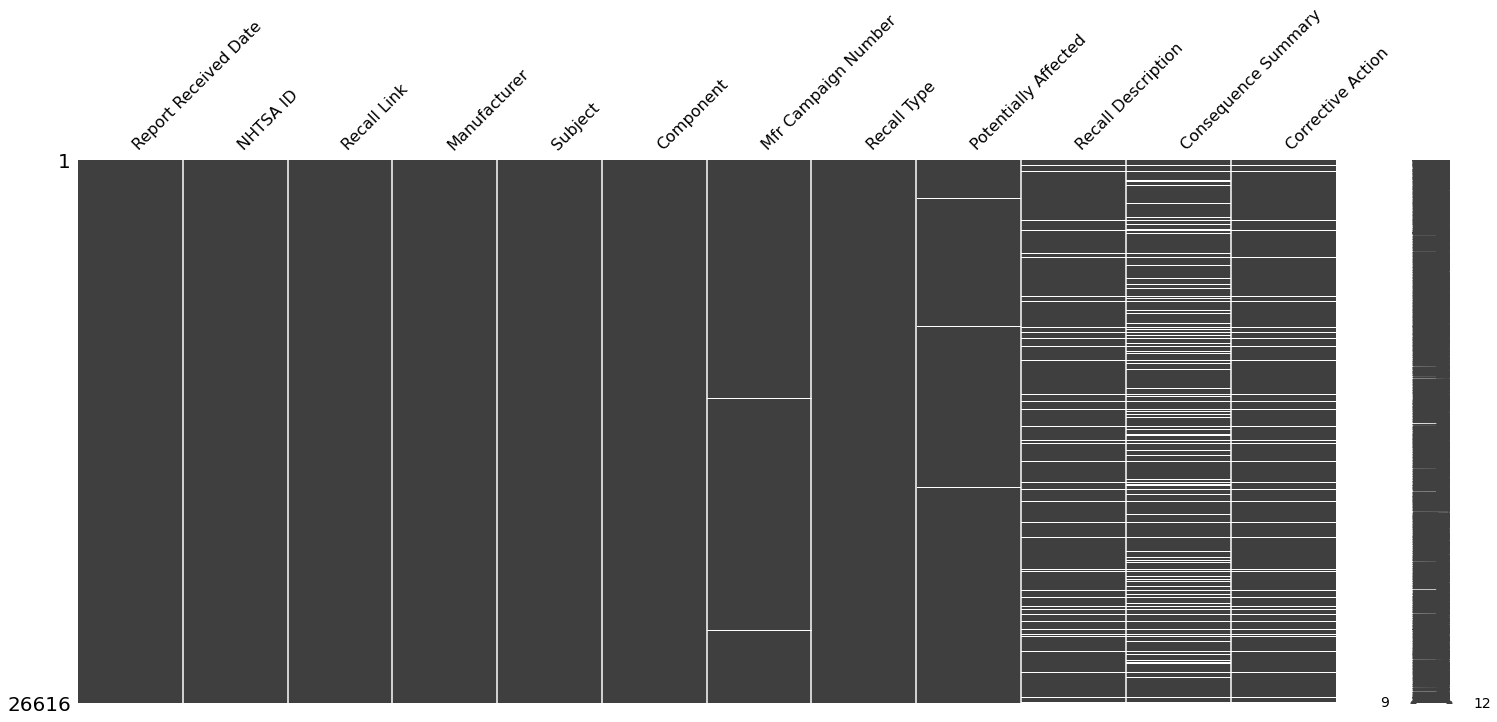

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26616 entries, 26557 to 4017
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Report Received Date  26616 non-null  object 
 1   NHTSA ID              26616 non-null  object 
 2   Recall Link           26616 non-null  object 
 3   Manufacturer          26616 non-null  object 
 4   Subject               26616 non-null  object 
 5   Component             26616 non-null  object 
 6   Mfr Campaign Number   26587 non-null  object 
 7   Recall Type           26616 non-null  object 
 8   Potentially Affected  26574 non-null  float64
 9   Recall Description    24215 non-null  object 
 10  Consequence Summary   21728 non-null  object 
 11  Corrective Action     24228 non-null  object 
dtypes: float64(1), object(11)
memory usage: 2.6+ MB
None


In [6]:
#Visualising missing data

#Sorting values by report received date
recalls_raw = recalls_raw.sort_values(by='Report Received Date',ascending=True)

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

In [7]:
#Separating recalls by potentially affected missing/complete
#affected_missing = recalls[recalls['Potentially Affected'].isna()]
#affected_complete = recalls[~recalls['Potentially Affected'].isna()]

#print(affected_missing.describe())
#print(affected_complete.describe())

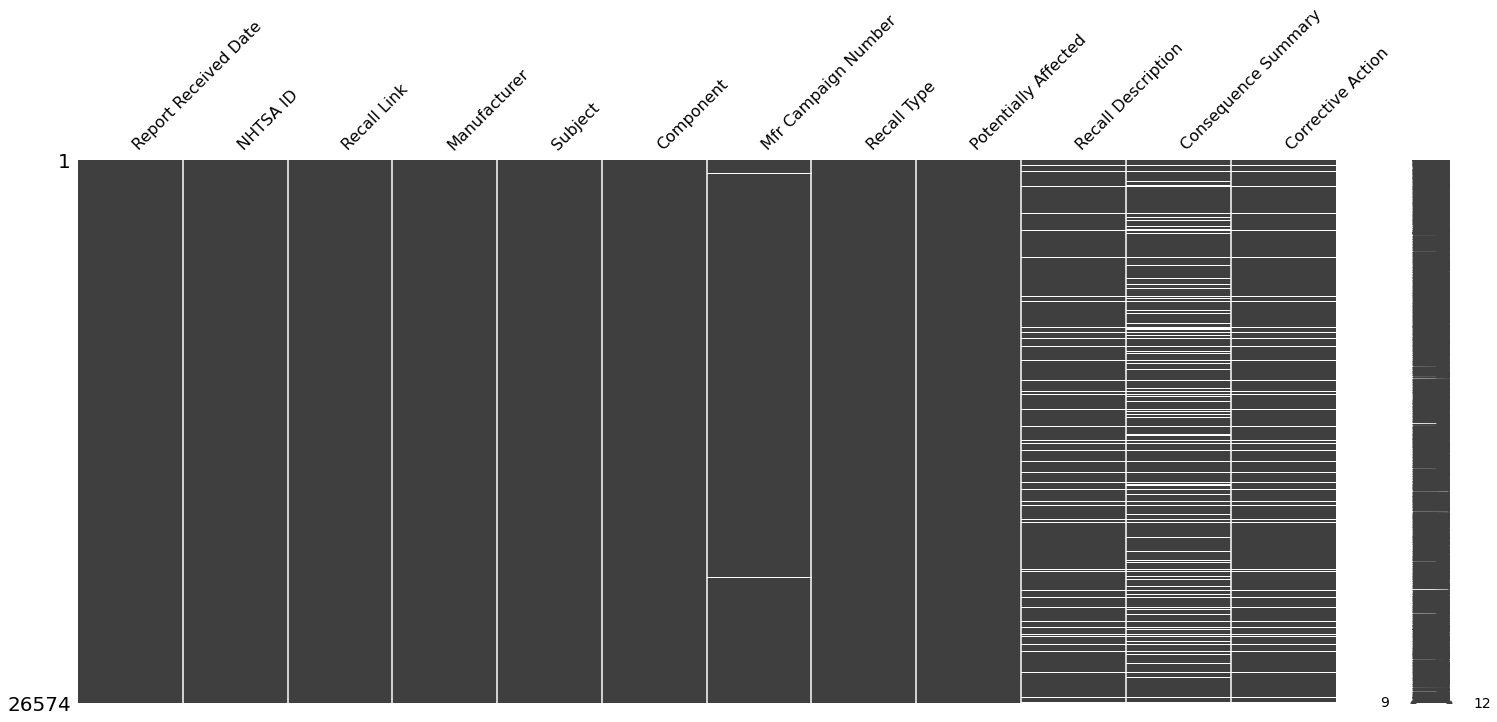

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26574 entries, 26557 to 4017
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Report Received Date  26574 non-null  object 
 1   NHTSA ID              26574 non-null  object 
 2   Recall Link           26574 non-null  object 
 3   Manufacturer          26574 non-null  object 
 4   Subject               26574 non-null  object 
 5   Component             26574 non-null  object 
 6   Mfr Campaign Number   26545 non-null  object 
 7   Recall Type           26574 non-null  object 
 8   Potentially Affected  26574 non-null  float64
 9   Recall Description    24173 non-null  object 
 10  Consequence Summary   21686 non-null  object 
 11  Corrective Action     24186 non-null  object 
dtypes: float64(1), object(11)
memory usage: 2.6+ MB
None


In [8]:
#dropping rows with missing 'Potentially Affected' data - irrelevant for analysis
recalls_raw = recalls_raw.dropna(subset = ['Potentially Affected'])

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

We can see that only the columns 'Mfr Campaign Number', 'Recall Description', 'Consequence Summary', and 'Corrective Action' now have missing data; this can be cleaned up using the fillna function

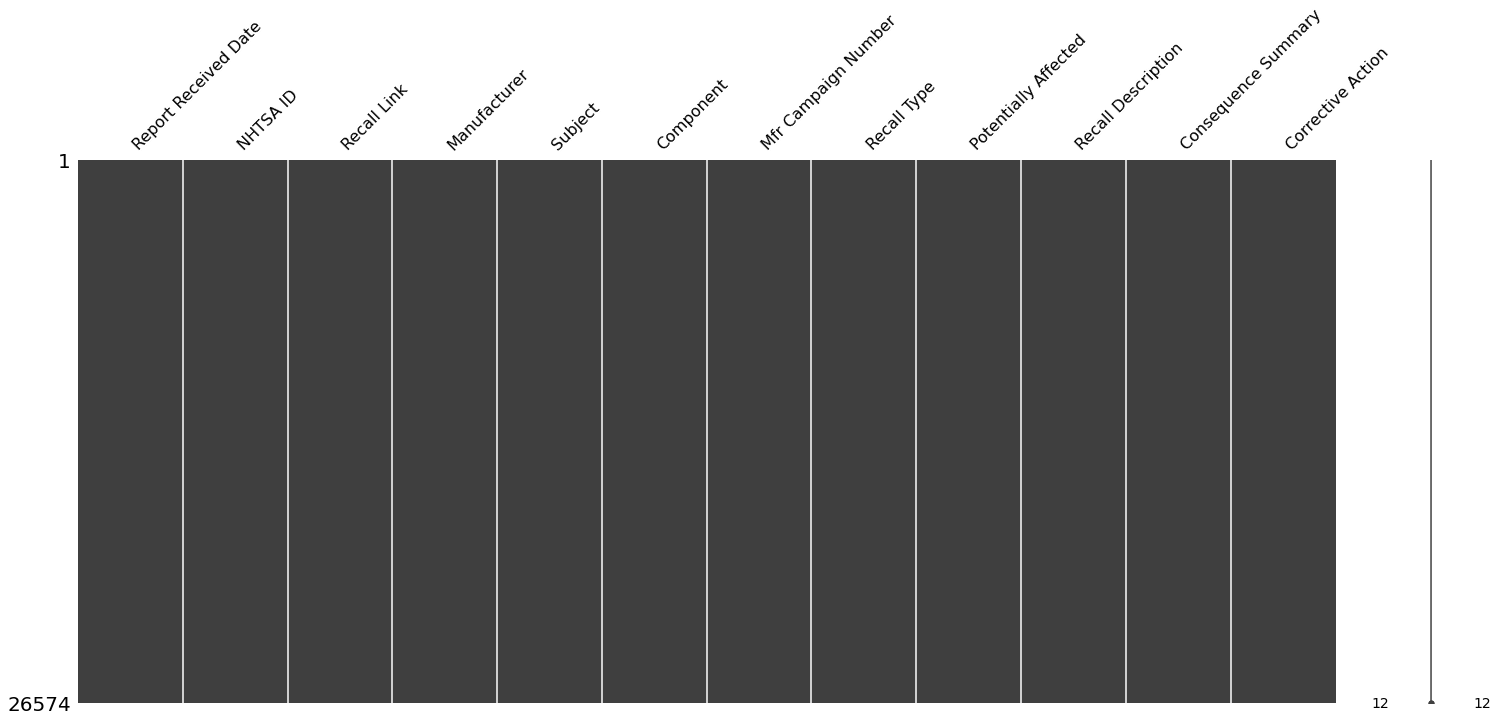

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26574 entries, 26557 to 4017
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Report Received Date  26574 non-null  object 
 1   NHTSA ID              26574 non-null  object 
 2   Recall Link           26574 non-null  object 
 3   Manufacturer          26574 non-null  object 
 4   Subject               26574 non-null  object 
 5   Component             26574 non-null  object 
 6   Mfr Campaign Number   26574 non-null  object 
 7   Recall Type           26574 non-null  object 
 8   Potentially Affected  26574 non-null  float64
 9   Recall Description    26574 non-null  object 
 10  Consequence Summary   26574 non-null  object 
 11  Corrective Action     26574 non-null  object 
dtypes: float64(1), object(11)
memory usage: 2.6+ MB
None


In [9]:
#filling in missing text data in text columns 
#text_cols = recalls_raw[['Recall Description','Consequence Summary','Corrective Action']]
recalls_raw = recalls_raw.fillna(value = 'Missing Info')

#plotting matrix of missing data
msno.matrix(recalls_raw)
plt.show()

#info of sorted data
print(recalls_raw.info())

## NLP Column Analysis: Corrective Action  

Problem Statement: The corrective action column needs to be classified in terms of response to the recall event
Method:
    1. Lemmatise the column to show only keywords - remove stopwords
    2. Use bigrams to pick out key phrases (i.e. "free charge" - recall was conducted free of charge)
    3. Generate list of key bigrams to highlight actions taken by the recall 

In [10]:
#reading in stopwords txt file to list

stopwords_file = 'excluded_words.txt'
stopwords_filepath = os.path.join(dir_name, stopwords_file)

with open(stopwords_filepath) as file:
    stopwords = set(file.read().split())

#print(stopwords)

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text) if w.lower() not in stopwords]

#creating new column in df for NLP analysis
#stripping out punctuation from corrective analysis - punctuation list
punct = '[' + string.punctuation + ']'

#removing punctuation and lemmatising column
recalls_raw['CA Lemm'] = recalls_raw['Corrective Action'].str.replace(punct,'',regex=True).apply(lemmatize_text) 

#converting column type to lowercase string for further analysis
recalls_raw['CA Lemm'] = recalls_raw['CA Lemm'].apply(str).apply(str.lower).str.replace(punct,'',regex=True)

print(recalls_raw.head())

      Report Received Date   NHTSA ID  \
26557           01/01/1967  67V011000   
26556           01/01/1967  67V010000   
25675           01/01/1972  72V025000   
24245           01/01/1977  77V013000   
24247           01/01/1977  77V010000   

                                             Recall Link  \
26557  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
26556  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
25675  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
24245  Go to Recall (https://www.nhtsa.gov/recalls?nh...   
24247  Go to Recall (https://www.nhtsa.gov/recalls?nh...   

                                   Manufacturer  \
26557                Nissan North America, Inc.   
26556                       General Motors, LLC   
25675  INTERNATIONAL TRUCK & ENGINE CORPORATION   
24245                         Mack Trucks, Inc.   
24247                          FREIGHTLINER LLC   

                                        Subject                  Component  \
26557  

In [11]:
from collections import Counter
Counter(" ".join(recalls_raw["CA Lemm"]).split()).most_common(80)

[('service', 11863),
 ('replace', 10490),
 ('notify', 9064),
 ('inspect', 4794),
 ('notification', 4608),
 ('install', 3561),
 ('vehicles', 3103),
 ('remedy', 2940),
 ('safety', 2781),
 ('repair', 2741),
 ('missing', 2706),
 ('vehicle', 2563),
 ('info', 2388),
 ('mailed', 2252),
 ('letter', 2202),
 ('brake', 2023),
 ('receive', 1935),
 ('replaced', 1826),
 ('affected', 1801),
 ('authorized', 1734),
 ('fuel', 1730),
 ('date', 1712),
 ('time', 1710),
 ('reasonable', 1626),
 ('assembly', 1517),
 ('agreed', 1473),
 ('provide', 1433),
 ('seat', 1410),
 ('expected', 1407),
 ('december', 1370),
 ('january', 1303),
 ('april', 1287),
 ('forest', 1249),
 ('campaign', 1187),
 ('february', 1161),
 ('front', 1153),
 ('correct', 1150),
 ('begin', 1150),
 ('2022', 1139),
 ('ford', 1132),
 ('replacement', 1120),
 ('control', 1111),
 ('rear', 1102),
 ('air', 1099),
 ('2021', 1052),
 ('manufacturer', 1044),
 ('2016', 1040),
 ('steering', 1031),
 ('2019', 1013),
 ('2018', 1005),
 ('notified', 964),
 ('20

In [12]:
#removing numbers in the analysis column
def remove_num(text):
    return re.sub(r'\d+', '', text)

#applying both functions to the Corrective Action Analysis column
recalls_raw['CA Lemm'] = recalls_raw['CA Lemm'].apply(remove_num)

In [13]:
Counter(" ".join(recalls_raw["CA Lemm"]).split()).most_common(80)

[('service', 11863),
 ('replace', 10490),
 ('notify', 9064),
 ('inspect', 4794),
 ('notification', 4608),
 ('install', 3561),
 ('vehicles', 3103),
 ('remedy', 2940),
 ('safety', 2781),
 ('repair', 2741),
 ('missing', 2706),
 ('vehicle', 2563),
 ('info', 2388),
 ('mailed', 2252),
 ('letter', 2202),
 ('brake', 2023),
 ('receive', 1935),
 ('replaced', 1826),
 ('affected', 1801),
 ('authorized', 1734),
 ('fuel', 1730),
 ('date', 1712),
 ('time', 1710),
 ('reasonable', 1626),
 ('assembly', 1517),
 ('agreed', 1473),
 ('provide', 1433),
 ('seat', 1410),
 ('expected', 1407),
 ('december', 1370),
 ('january', 1303),
 ('april', 1288),
 ('forest', 1249),
 ('campaign', 1187),
 ('february', 1161),
 ('front', 1153),
 ('correct', 1150),
 ('begin', 1150),
 ('ford', 1132),
 ('replacement', 1120),
 ('control', 1111),
 ('rear', 1102),
 ('air', 1099),
 ('manufacturer', 1044),
 ('steering', 1031),
 ('notified', 964),
 ('please', 922),
 ('label', 909),
 ('performed', 884),
 ('installed', 873),
 ('customers'

In [14]:
#postprocessing lemmatised words to reduce variations with word inflections
inflect_dict = {'notification':'notify',
                'replaced':'replace',
                'replacement':'replace',
                'installed':'install'}

#function to replace inflections
def replace_inflections(string):
    for inflection, replacement in inflect_dict.items():
        string = string.replace(inflection, replacement)
    return string

#applying to column
recalls_raw["CA Lemm"] = recalls_raw["CA Lemm"].apply(replace_inflections)

In [15]:
Counter(" ".join(recalls_raw["CA Lemm"]).split()).most_common(80)

[('notify', 13672),
 ('replace', 13436),
 ('service', 11863),
 ('inspect', 4794),
 ('install', 4434),
 ('vehicles', 3103),
 ('remedy', 2940),
 ('safety', 2781),
 ('repair', 2741),
 ('missing', 2706),
 ('vehicle', 2563),
 ('info', 2388),
 ('mailed', 2252),
 ('letter', 2202),
 ('brake', 2023),
 ('receive', 1935),
 ('affected', 1801),
 ('authorized', 1734),
 ('fuel', 1730),
 ('date', 1712),
 ('time', 1710),
 ('reasonable', 1626),
 ('assembly', 1517),
 ('agreed', 1473),
 ('provide', 1433),
 ('seat', 1410),
 ('expected', 1407),
 ('december', 1370),
 ('january', 1303),
 ('april', 1288),
 ('forest', 1249),
 ('campaign', 1187),
 ('february', 1161),
 ('front', 1153),
 ('correct', 1150),
 ('begin', 1150),
 ('ford', 1132),
 ('control', 1111),
 ('rear', 1102),
 ('air', 1099),
 ('manufacturer', 1044),
 ('steering', 1031),
 ('notified', 964),
 ('please', 922),
 ('label', 909),
 ('performed', 884),
 ('customers', 866),
 ('tire', 861),
 ('river', 846),
 ('e', 833),
 ('software', 821),
 ('kit', 816),
 

In [16]:
#counting number of rows in the corrective action column that contain at least one keyword

keywords = ['service','replace','notify','inspect','install','repair','missing info']

match_count = 0

for row in recalls_raw["CA Lemm"]:
    for word in keywords:
        if word in row:
            match_count +=1
            break

print(match_count)
print(keywords)

24926
['service', 'replace', 'notify', 'inspect', 'install', 'repair', 'missing info']


The majority of the lemmatised rows in 'CA Lemm' now contains at least one keyword, or 'missing info' (24926 against the total 26574 rows). Let's subset the remaining rows which don't contain these keywords to determine the most common lemmatised words in these instances. 

In [19]:
def subset_no_keywords(wordlist, data):
    return [row for row in data if all(word not in row for word in wordlist)]

recalls_no_keyword = subset_no_keywords(keywords,recalls_raw['CA Lemm']) 
print(recalls_no_keyword)

['secure clamp bolt modifications lower steering shaft', 'secure auxiliary fuel tank frame steel bands straps bolted frame rail floor joist', 'reposition tighten proper torque level fuel hose clamp', 'refund purchase price returned flashers', 'cut center floor support tube forward prevent puncturing fuel tank rear impact collision', 'add  inch  inch strap rearmost seats', 'adjust torque outer wheel nuts', 'torque suspect fasteners proper specifications', 'pamphlet sent consumers', 'electronic fuel control bypass valve redesigned prevent loss throttle control pace sysems operating cruise control', 'correct wiring cruise control', 'flyer reprogram instrument panel safety january   flyer upload corrected software version flyer ', 'tighten air bag curtain fasteners proper specification january   daimlerchrysler ', 'reflash electronic control unit safety february   ducati ', 'tighten securing nut proper specifications involved vehicles', 'readjust horn bracket angle reroute secure shaped co

In [20]:
Counter(" ".join(recalls_no_keyword).split()).most_common(80)

[('ricon', 343),
 ('correct', 269),
 ('please', 188),
 ('e', 174),
 ('wheelchair', 141),
 ('brake', 132),
 ('lifts', 124),
 ('vehicles', 113),
 ('air', 107),
 ('safety', 95),
 ('remove', 94),
 ('control', 93),
 ('provide', 85),
 ('system', 83),
 ('pressure', 82),
 ('fuel', 81),
 ('remedy', 81),
 ('add', 80),
 ('vehicle', 79),
 ('reroute', 78),
 ('provided', 74),
 ('reprogram', 73),
 ('valve', 70),
 ('seat', 69),
 ('prevent', 68),
 ('front', 66),
 ('torque', 63),
 ('bolts', 63),
 ('modify', 63),
 ('proper', 62),
 ('wiring', 61),
 ('rear', 60),
 ('instructions', 60),
 ('labels', 59),
 ('campaign', 59),
 ('wheel', 57),
 ('corrected', 57),
 ('label', 57),
 ('bracket', 56),
 ('information', 56),
 ('tighten', 53),
 ('steering', 51),
 ('refund', 50),
 ('affected', 50),
 ('bus', 49),
 ('secure', 48),
 ('harness', 48),
 ('properly', 47),
 ('expected', 47),
 ('begin', 47),
 ('return', 47),
 ('frame', 46),
 ('cable', 44),
 ('relief', 44),
 ('module', 43),
 ('customers', 43),
 ('position', 43),
 (

In [22]:
#adding new keywords to keyword list
keywords = keywords+['remove','reroute','relocate','reprogram','modify']

#adding entries to the inflection replacement dictionary for modify inflections/synonyms
inflect_dict.update({'modification':'modify',
                     'modifications':'modify',
                     'adjust':'modify',
                     'reposition':'modify',
                     'provided':'replace',
                     'provide':'replace'})

#applying new inflections to column
recalls_raw["CA Lemm"] = recalls_raw["CA Lemm"].apply(replace_inflections)

match_count = 0

for row in recalls_raw["CA Lemm"]:
    for word in keywords:
        if word in row:
            match_count +=1
            break

print(match_count)

25516


In [23]:
recalls_no_keyword = subset_no_keywords(keywords,recalls_raw['CA Lemm']) 
print(recalls_no_keyword)

['secure auxiliary fuel tank frame steel bands straps bolted frame rail floor joist', 'refund purchase price returned flashers', 'cut center floor support tube forward prevent puncturing fuel tank rear impact collision', 'add  inch  inch strap rearmost seats', 'torque suspect fasteners proper specifications', 'pamphlet sent consumers', 'electronic fuel control bypass valve redesigned prevent loss throttle control pace sysems operating cruise control', 'correct wiring cruise control', 'tighten air bag curtain fasteners proper specification january   daimlerchrysler ', 'reflash electronic control unit safety february   ducati ', 'tighten securing nut proper specifications involved vehicles', 'retorque pinch bolts reset', 'vehicles possessions', 'bluecar notified purchaser affected vehicle remedy replacing gear shift newly designed gear lever begun', 'corrected information plates supplied manufacturer cost', 'add retaining brackets prevent tv moving cabinet', 'correct certification labels

In [24]:
Counter(" ".join(recalls_no_keyword).split()).most_common(80)

[('ricon', 278),
 ('correct', 233),
 ('please', 162),
 ('e', 153),
 ('wheelchair', 140),
 ('lifts', 124),
 ('air', 80),
 ('vehicles', 75),
 ('pressure', 68),
 ('add', 66),
 ('brake', 66),
 ('valve', 56),
 ('bolts', 52),
 ('fuel', 49),
 ('tighten', 49),
 ('remedy', 48),
 ('vehicle', 47),
 ('torque', 45),
 ('safety', 45),
 ('system', 45),
 ('prevent', 44),
 ('refund', 43),
 ('relief', 43),
 ('seat', 43),
 ('return', 42),
 ('corrected', 41),
 ('wheel', 41),
 ('front', 40),
 ('proper', 39),
 ('control', 39),
 ('bracket', 39),
 ('bus', 38),
 ('dryer', 38),
 ('labels', 37),
 ('instructions', 37),
 ('specifications', 34),
 ('affected', 34),
 ('properly', 34),
 ('information', 33),
 ('notified', 32),
 ('campaign', 32),
 ('steering', 32),
 ('frame', 31),
 ('label', 31),
 ('expected', 30),
 ('secure', 29),
 ('rear', 29),
 ('retorque', 29),
 ('manufacturer', 29),
 ('begin', 29),
 ('purchase', 28),
 ('nut', 28),
 ('vent', 28),
 ('price', 27),
 ('coach', 27),
 ('wiring', 26),
 ('mounting', 25),
 ('

In [ ]:
#finding bigrams
def generate_bigrams(s):
    tokens = nltk.word_tokenize(s.lower())
    return list(nltk.ngrams(tokens, 2))

recalls_raw['CA bigrams'] = recalls_raw['CA Stem'].apply(str).apply(generate_bigrams)

# create a list of ngrams from all the rows
all_bigrams = [bigram for row in recalls_raw['CA bigrams'] for bigram in row]

# count the ngrams and return the 40 most common ones
most_common_bigrams = Counter(all_bigrams).most_common(40)

print(most_common_bigrams)

In [ ]:
#finding trigrams
def generate_trigrams(s):
    tokens = nltk.word_tokenize(s.lower())
    return list(nltk.ngrams(tokens, 3))

recalls_raw['CA trigrams'] = recalls_raw['CA Stem'].apply(str).apply(generate_trigrams)

# create a list of ngrams from all the rows
all_trigrams = [trigram for row in recalls_raw['CA trigrams'] for trigram in row]

# count the ngrams and return the 40 most common ones
most_common_trigrams = Counter(all_trigrams).most_common(40)

print(most_common_trigrams)

## Export Data for Power BI Analysis

In [ ]:
#exporting to csv for PBI report
recalls_raw.to_csv('pbi_recalls_data.csv',index=False)